In [ ]:
#default_exp core.train

In [ ]:
#export
import torch
from torch import nn
from torch.nn import functional as F
from vase.config import DATA_PATH, PARAM_PATH
from vase.core.utils import rec_likelihood, kl_div_stdnorm


In [ ]:
#hide
from vase.core.models import FCEncoder, FCDecoder, Encoder, Decoder, PaperVanillaVAE, FCVAE, LatentMaskVAE
from vase.core.datasets.moving_mnist import MovingFashionMNIST, MovingMNIST, CommonMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from  datetime import datetime as dt

In [ ]:
train = False
latents=24
batch_size=64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
fc_vae_helper = FCVAE(latents)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
rec, mu, logvar = fc_vae_helper(mnist_batch)
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, batch_size, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()
mm_data = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
mm_loader = DataLoader(mm_data, batch_size, shuffle=True)
mm_batch, _, _ = iter(mm_loader).next()

# Training For VASE
> all losses and training code for VASE (variational inference, environmental inference, latent masking, generative replay, object classification, location regresion)

## Problem Setup

TODO: add all the distributions

## Standard VAE (Reconstruction + Target KL)
The paper's "The Minimum Length Description (MDL)" loss is a variannt of the standard VAE ELBO loss, maximimzing the likelihood while minimizing the KL Divergence to the prior:

$$\mathcal{L}_{MDL}(\phi, \theta) = E_{\mathbf{z}^s \sim q_{\phi}(\dot|\mathbf{x}^s)}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z}^s, s)}] + \gamma |KL(q_{\phi}(\mathbf{z}^s|\mathbf{x}^s)||p(z)) - C|$$


However, you'll notice the KL divergence term is slighly non-standard. Rather than penalizing the KLDiv at a fixed rate, the loss is the difference between the KLDiv and a dynamic target $C$, which increases over the course of training, allowing for gradually more representation capacity. This trick was taken from [Understanding disentanglement in the $\beta$-VAE](https://arxiv.org/pdf/1804.03599.pdf) (Note that in keeping with that paper, I have dropped the square from the KL term)

For now we'll also drop the environment super script s, just training an autoencoder on iid data:

$$\mathcal{L}_{MDL}(\phi, \theta) = E_{\mathbf{z} \sim q_{\phi}(\dot|\mathbf{x})}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z})}] + \gamma |KL(q_{\phi}(\mathbf{z}|\mathbf{x})||p(z)) - C|$$

### Reconstruction Loss
$$E_{\mathbf{z}^s \sim q_{\phi}(\dot|\mathbf{x}^s)}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z}^s, s)}]$$

In [ ]:
#export 
def reconstruction_loss(x, x_rec):
    """Returns mean reconstruction loss across batch"""
    return torch.mean(rec_likelihood(x, x_rec))

### KL Div Target Loss

#### KLDiv Target Loss

Now we can define the full loss:

$$\gamma |KL(q_{\phi}(\mathbf{z}^s|\mathbf{x}^s)||p(z)) - C|$$

I'm not sure if the difference is computed element wise, or by batch....

In [ ]:
#export
def kl_div_target(mu, logvar, C=0, gamma=1):
    """Returns target loss: squared difference of mean kldivergence and target C scaled by gamma"""
    return gamma * torch.mean(torch.abs((kl_div_stdnorm(mu, logvar) - C)))

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1]))) == 0

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1])), C=1) == 1

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1])), C=2, gamma=3) == 6

### Train 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Hyper Parameters
The original payer uses $\gamma=100$, but will a scaling $C$ and 24 available latents (8 of which are actually used). For now we'll use a fixed C and define 8 latents (all of which are available to the VAE) 

In [ ]:
gamma=100
lr=1e-3
batch_size = 64
latents=8
C=0
epochs = 1

In [ ]:
vanilla_vae = PaperVanillaVAE(latents=latents, device=device) #VanillaVAE(latents=latents)
optimizer = torch.optim.Adam(params = vanilla_vae.parameters(), lr=lr)
loader = DataLoader(fashion_data, batch_size, shuffle=True) #DataLoader(fashion_data, batch_size)

In [ ]:
vanilla_vae.to(device)

PaperVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=8, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padd

In [ ]:
if not train:
    epochs = 0

In [ ]:
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y, _pos in loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_X, mu, logvar = vanilla_vae(X)

        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        loss = rec_loss + kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")

In [ ]:
if train:
    torch.save(vanilla_vae.state_dict(), os.path.join(PARAM_PATH, 'vae_fashion'))
state_dict = torch.load(os.path.join(PARAM_PATH, 'vae_fashion'), map_location=torch.device(device))
vanilla_vae.load_state_dict(state_dict=state_dict)
vanilla_vae.eval()

PaperVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=8, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padd

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar = vanilla_vae(fashion_batch)

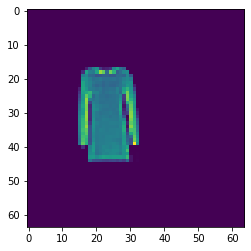

In [ ]:
plt.imshow(fashion_batch[0].cpu().detach().numpy().squeeze())

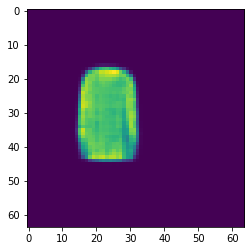

In [ ]:
plt.imshow(rec_img[0].cpu().detach().numpy().squeeze())

## Latent Masking VAE

### Train

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
lam=0.4
gamma=100
lr=1e-3
latents=8
C=0
epochs = 30 #30 for movign fashion, 20 for mnist (change to 64x64), 30 for moving mnist
model_save_steps = 2500 #save model after this many "training steps"? (batchs, ~once every 2.5 epochs
exp_name = 'latent_mask_fashion'
steps_per_save = 2500

In [ ]:
save_dir = os.path.join(PARAM_PATH, exp_name + dt.now().strftime('%m_%d_%y_%H_%M_%S'))
os.mkdir(save_dir)

In [ ]:
masked_vae = LatentMaskVAE(encoder=Encoder, decoder=Decoder, latents=latents, device=device, lam=lam) #VanillaVAE(latents=latents)
optimizer = torch.optim.Adam(params = masked_vae.parameters(), lr=lr)

In [ ]:
steps = 0
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y, in mnist_loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_X, mu, logvar = masked_vae(X)

        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        loss = rec_loss + kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
        
        #save model for training regression and classification 
        if steps % steps_per_save == 0:
            torch.save(masked_vae.state_dict(), os.path.join(save_dir, f"step_{steps}"))

        steps += 1
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")

epoch: 0, loss=3415.86767578125, rec_loss=3328.5263671875, total_div_loss=87.34221649169922
epoch: 1, loss=2206.018798828125, rec_loss=2035.5357666015625, total_div_loss=170.4826202392578
epoch: 2, loss=2036.918212890625, rec_loss=1844.1099853515625, total_div_loss=192.80853271484375
epoch: 3, loss=1966.20263671875, rec_loss=1765.571533203125, total_div_loss=200.63272094726562
epoch: 4, loss=1925.833984375, rec_loss=1721.712158203125, total_div_loss=204.1197052001953
epoch: 5, loss=1900.8863525390625, rec_loss=1694.83935546875, total_div_loss=206.04751586914062
epoch: 6, loss=1885.1361083984375, rec_loss=1677.045654296875, total_div_loss=208.0904998779297
epoch: 7, loss=1872.745361328125, rec_loss=1663.4752197265625, total_div_loss=209.26882934570312
epoch: 8, loss=1862.681884765625, rec_loss=1652.3663330078125, total_div_loss=210.3151397705078
epoch: 9, loss=1855.81787109375, rec_loss=1644.3988037109375, total_div_loss=211.41766357421875
epoch: 10, loss=1849.213623046875, rec_loss=163

In [ ]:
if train:
    torch.save(masked_vae.state_dict(), os.path.join(save_dir, "final"))
state_dict = torch.load(os.path.join(save_dir, "final"), map_location=torch.device(device))
masked_vae.load_state_dict(state_dict=state_dict)
masked_vae.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/oliverdaniels-koch/NotebookProjects/lifelong_disrep/vase/params/latent_mask_mnist04_27_22_12_17_50/final'

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar = masked_vae(fashion_batch)

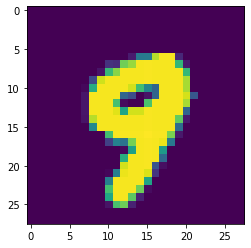

In [ ]:
plt.imshow(fashion_batch[0].detach().numpy().squeeze())

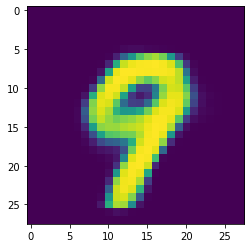

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze())

In [ ]:
#moving fashion training

In [ ]:
#mnist training

In [ ]:
#moving mnist training

In [ ]:
#define hyperparams
#define model
#define optimizer

In [ ]:
#train on moving fashion mnist
#train on moving mnist

## Classification and Regression